# Кластеризация

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

np.set_printoptions(suppress=True)

In [2]:
random.seed(42)

In [3]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

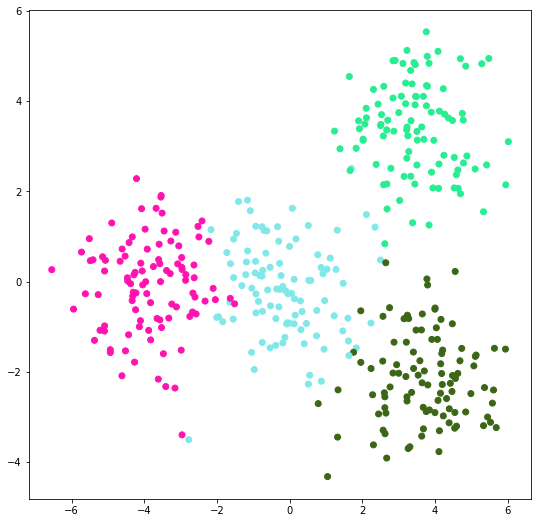

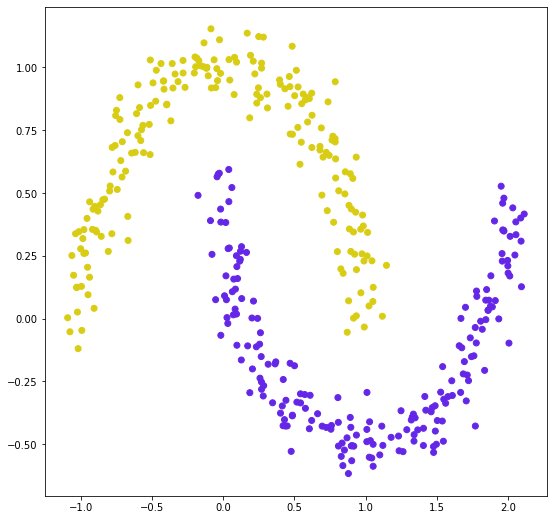

In [4]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [5]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300, tol: float = 1e-10):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.tol = tol
        
    def __init_centroids__(self, X, n_reinit):
        
        if self.init == 'random':
            return np.random.rand(n_reinit, len(X[0]))
        elif self.init == 'sample':
            return list(map(lambda i : X[i], np.random.choice(a=len(X), size=n_reinit, replace=False)))
        else:
            if not hasattr(self, 'centroids'):
                centroids = list(np.random.choice(a=len(X), size=1))
            else:
                centroids = self.centroids
            
            nearest_centroid_indices = [np.argmin(list(map(lambda center: np.linalg.norm(X[center] - X[i]),centroids))) for i in range(len(X))]
            
            for _ in range(n_reinit - 1):
                distances_square = [np.linalg.norm(np.square(X[nearest_centroid_indices[index]] - x)) for index, x in enumerate(X)]
                prefix_distances_square_sum = np.cumsum(distances_square)
                
                chosen_interval_point = random.random() * prefix_distances_square_sum[-1]
                
                new_centroid_index = np.argmax(prefix_distances_square_sum > chosen_interval_point)

                for index, x in enumerate(X):
                    if np.linalg.norm(X[nearest_centroid_indices[index]] - x) > np.linalg.norm(X[new_centroid_index] - x):
                        nearest_centroid_indices[index] = new_centroid_index
                
                centroids.append(new_centroid_index)
                
            return list(map(lambda i : X[i], centroids))
                            
        
    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        
        self.centroids = self.__init_centroids__(X, n_reinit=self.n_clusters)
        
        for _ in range(self.max_iter):
            
            new_centroids = np.zeros(shape=(len(self.centroids), len(X[0]) + 1)) # sum of datums in cluster, number of points in cluster
            
            for x in X:
                index = np.argmin(list(map(lambda center: np.linalg.norm(center - x), self.centroids)))
                
                for i in range(len(X[0])):                 
                    new_centroids[index][i] += x[i]
                    
                new_centroids[index][-1] += 1
                
            new_centroids = list(map(lambda x: np.array(list(x)[:len(x) - 1]) / x[-1], list(filter(lambda x: x[-1] != 0, new_centroids))))
            
            if len(new_centroids) != self.n_clusters:
                print(self.n_clusters - len(new_centroids))
                new_centroids = [*new_centroids, *self.__init_centroids__(X, n_reinit=self.n_clusters - len(new_centroids))]
            
            if max(map(lambda x: np.linalg.norm(x[0] - x[1]), zip(self.centroids, new_centroids))) < self.tol:
                break
            
            self.centroids = new_centroids
    
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        return [np.argmin(list(map(lambda center: np.linalg.norm(center - x), self.centroids))) for x in X]

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

1


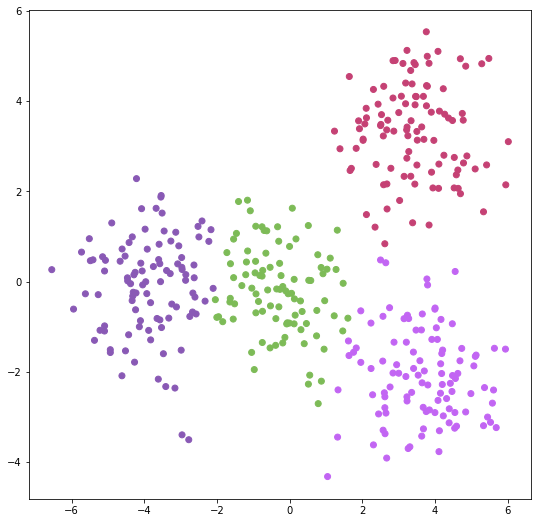

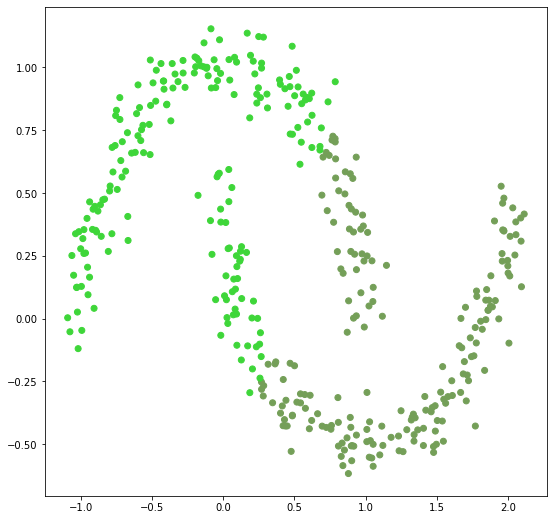

In [6]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [7]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        
        kd_tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        adjectives = [[]] * len(X)
        
        core_samples = [index for index, x in enumerate(X) if len(kd_tree.query_radius([x], r=self.eps)[0]) >= self.min_samples]
        
        for core_sample in core_samples:
            adjectives[core_sample] = kd_tree.query_radius([X[core_sample]], r=self.eps)[0]
            
        self.cc = [0] * len(X) # 0 mean a noises class.
        
        component_number = 1
        for core_sample in core_samples:
            if self.cc[core_sample] == 0:
                self.__dfs_cc__(adjectives, core_sample, component_number)
                component_number += 1
                
        # if noise-component doesn't exist in answer then shift groups to 1 to the left.
        return self.cc if 0 in self.cc else list(map(lambda x: x - 1, self.cc))
                
    def __dfs_cc__(self, adjectives, vertex_number, component_number):
        if self.cc[vertex_number] != 0:
            return
        
        self.cc[vertex_number] = component_number
        
        for neighbour in adjectives[vertex_number]:
            self.__dfs_cc__(adjectives, neighbour, component_number)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

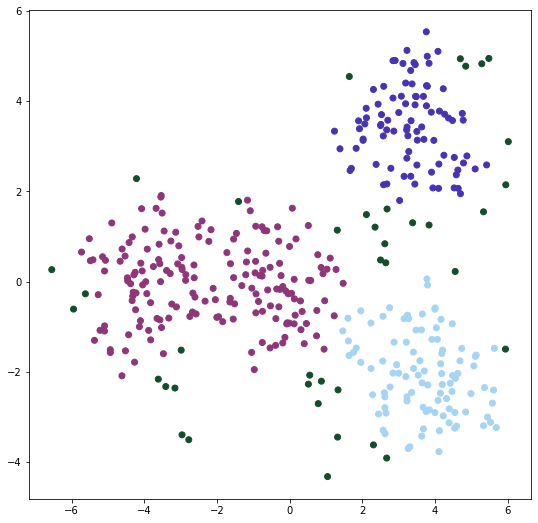

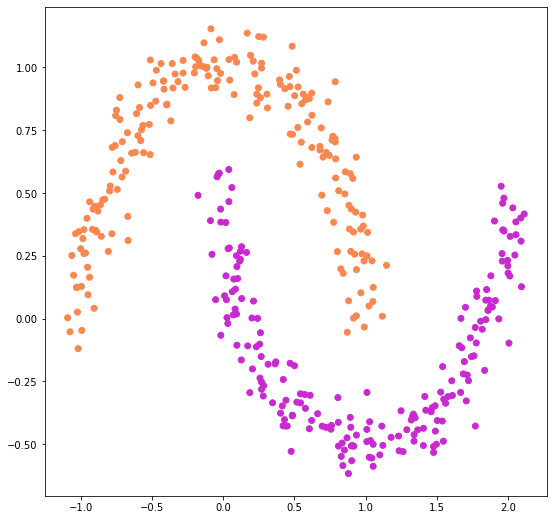

In [8]:
dbscan = DBScan(eps=0.7, min_samples=9)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [10]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        
        self.n_clusters = n_clusters
        self.linkage = linkage
    
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
                
        indexed_clusters = [[i] for i in range(len(X))]
        alive_indexes = [i for i in range(len(X))]
        
        self.cluster_distances = [[self.__calc_distance__(X, indexed_clusters[i], indexed_clusters[j]) for i in range(len(X))] for j in range(len(X))]
        
        while len(alive_indexes) > self.n_clusters:
            a, b = self.__get_closest_couple__(alive_indexes, indexed_clusters)
            indexed_clusters[a] = [*indexed_clusters[a], *indexed_clusters[b]]
            alive_indexes.remove(b)
            
            for i in alive_indexes:
                new_dist = self.__calc_distance__(X, indexed_clusters[a], indexed_clusters[i])
                self.cluster_distances[a][i] = min(self.cluster_distances[a][i], new_dist)
                self.cluster_distances[i][a] = min(self.cluster_distances[i][a], new_dist)
                    
        results = [0] * len(X)
        for cluster_pos, i in enumerate(alive_indexes):
            for elem in indexed_clusters[i]:
                results[elem] = cluster_pos
        
        return results

    def __get_closest_couple__(self, alive_indexes, indexed_clusters):
        a, b = alive_indexes[0], alive_indexes[1]
        dist = 1e100
        for i in alive_indexes:
            for j in alive_indexes:
                if i < j:
                    if dist > self.cluster_distances[i][j]:
                        dist = self.cluster_distances[i][j]
                        a, b = i, j
                    
        return a, b
                    
    def __calc_distance__(self, X, first_cluster, second_cluster):
        if self.linkage == 'average':
            return np.mean([np.linalg.norm(X[x] - X[y]) for x in first_cluster for y in second_cluster], axis=0)
        elif self.linkage == 'single':
            return min([np.linalg.norm(X[x] - X[y]) for x in first_cluster for y in second_cluster])
        else:
            return max([np.linalg.norm(X[x] - X[y]) for x in first_cluster for y in second_cluster])

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

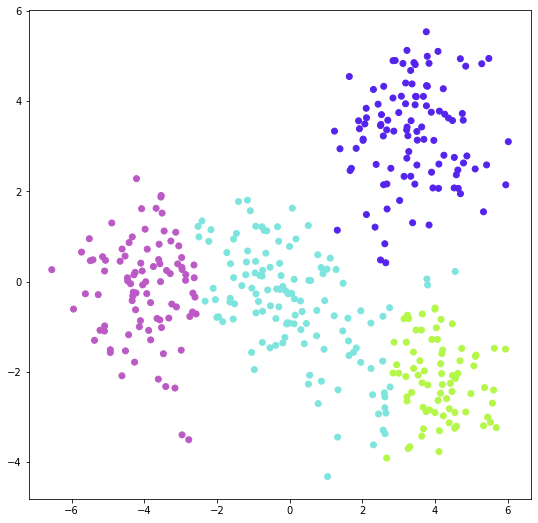

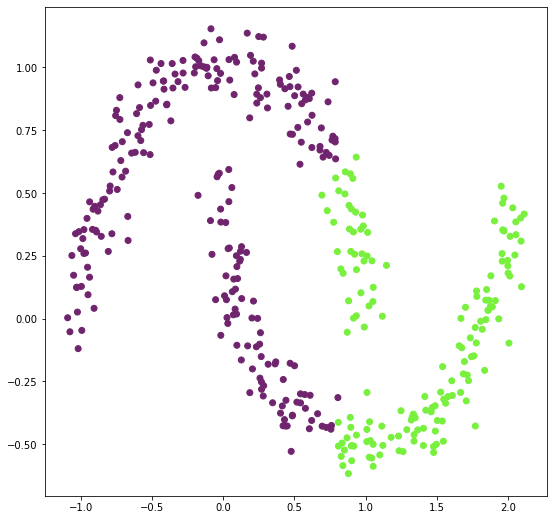

In [11]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__indexed_clusters

In [12]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    v = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    return v / 255

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    image = cv2.cvtColor(np.float32(image) * 255, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

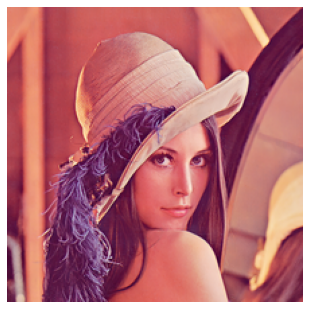

In [13]:
show_image(read_image("./image.png"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [14]:
def clusterize_image(image, **kwargs):
    kmeans = KMeans(n_clusters=3, init='k-means++')
    
    X = [y for x in image for y in x]
    
    cluster_colors = [[0, 1, 0], [1, 0, 0], [0, 0, 1]]
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    
    recolored = np.zeros(shape=(len(image), len(image[0]), len(image[0][0])))
    for index, cluster in enumerate(clusters):
        recolored[index // len(image[0])][index % len(image[0])] = cluster_colors[cluster]
    
    clusters_statistics(image.reshape(-1, 3), [[0, 1, 0], [1, 0, 0], [0, 0, 1]], clusters) # Very slow (:
    return recolored

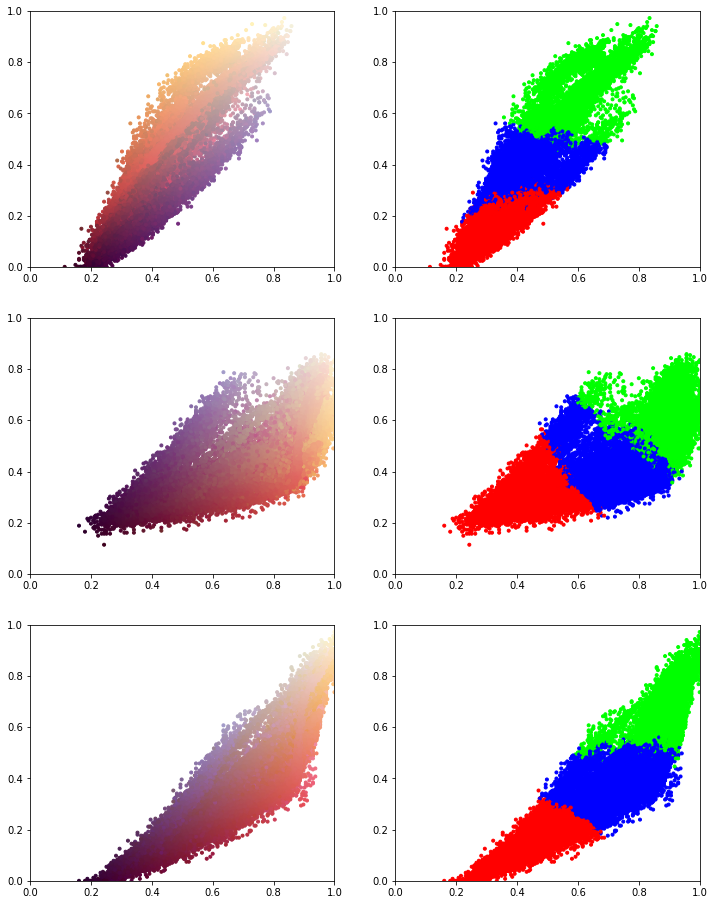

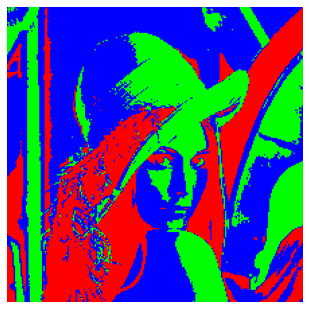

In [15]:
image = read_image("./image.png")
result = clusterize_image(image)
show_image(result)
save_image(result, "result.png")